In [1]:
import sys

sys.path.append("../src/")

import os
import pathlib
from collections import defaultdict
from typing import Any, Dict, Optional, Union

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import xgboost
import lightgbm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from rich.progress import track

from utils.io import load_pickle, save_pickle, save_txt

%matplotlib inline


sns.set_style("darkgrid")
plt.style.use("seaborn-darkgrid")

pd.options.display.max_rows = 100
pd.options.display.max_columns = 500 

/tmp/ipykernel_666/1243132021.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [2]:
model_dir = pathlib.Path("../data/models/")

In [3]:
levelGroup_levels = {"0-4": (1, 4), "5-12": (4, 14), "13-22": (14, 19)}

In [4]:
N_FOLD = 5

models_xgb = {}
models_lgbm = {}

for level_group, levels in levelGroup_levels.items():
    models_xgb[level_group] = []
    models_lgbm[level_group] = []
    for level in range(*levels):
        for fold in range(N_FOLD):
            model = XGBClassifier()
            model.load_model(model_dir / f"model_xgb_fold_{fold}_level_{level}.json")
            models_xgb[level_group].append(model)

            model = lightgbm.Booster(
                model_file=str(model_dir / f"model_lgbm_fold_{fold}_level_{level}.txt")
            )
            models_lgbm[level_group].append(model)

In [5]:
fscores = {}

for level_group, levels in levelGroup_levels.items():
    fscore_list = []
    for fold in range(N_FOLD):
        fscore_list.append(models_xgb[level_group][fold].get_booster().get_score(importance_type="gain"))

    fscore = pd.DataFrame(fscore_list).mean(axis=0).sort_values()
    fscores[level_group] = fscore

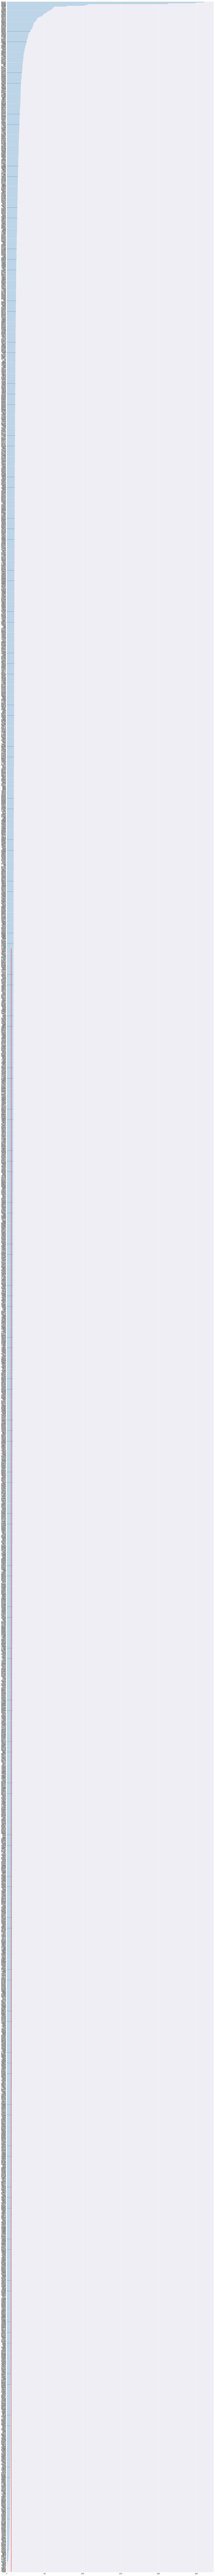

In [6]:
threshold = 6.0

fscores["13-22"].plot.barh(figsize=(20, 250))
plt.vlines(threshold, 0, 2000, "red")  # type: ignore

In [17]:
# thresholds = [5.0, 5.0, 12.0]


# for i, (level_group, fscore) in enumerate(fscores.items()):
#     drop_features = fscore[fscore < thresholds[i]].index.tolist()
#     drop_features = [f.replace(f"_{level_group}", "") for f in drop_features if level_group in f]
#     print(level_group, len(drop_features))

#     save_pickle(f"../data/feature/cols_low_fi_{level_group}.pkl", drop_features)

0-4 51
5-12 204
13-22 373


In [18]:
drop_features

['fqid_tocage_count',
 'name_prev_elapsed_time_diff_max',
 'room_fqid_tunic.kohlcenter.halloffame_count',
 'fqid_unlockdoor_count',
 'elapsed_time_diff_qtile_0.5',
 'name_prev_elapsed_time_diff_sum',
 'fqid_reader_flag.paper2.prev_elapsed_time_diff_mean',
 'text_fqid_tunic.flaghouse.entry.flag_girl.symbol_count',
 'text_fqid_tunic.library.frontdesk.worker.flag_recap_count',
 'fqid_reader_flag.paper2.prev_elapsed_time_diff_max',
 'level_19_elapsed_time_diff_min',
 'fqid_journals_flag.pic_1.bingo_count',
 'name_prev_elapsed_time_diff_min',
 'room_fqid_tunic.library.frontdesk_elapsed_time_diff_sum',
 'word_mean_can',
 'event_name_notebook_click_elapsed_time_diff_max',
 'text_fqid_tunic.historicalsociety.cage.confrontation_elapsed_time_diff_mean',
 'event_name_person_click_count',
 'text_fqid_tunic.historicalsociety.cage.confrontation_elapsed_time_diff_sum',
 'fqid_journals_flag.hub.topics_old_elapsed_time_diff_mean',
 'level_14_count',
 'fqid_archivist_glasses_count',
 'room_fqid_tunic.ca

In [76]:
# for i in range(N_FOLD):
#     lightgbm.plot_importance(models_lgbm[i], max_num_features=20, importance_type="gain")

In [20]:
N_FOLD = 5

models_xgb = {}
models_lgbm = {}

for level_group, levels in levelGroup_levels.items():
    models_xgb[level_group] = {}
    models_lgbm[level_group] = {}
    for level in range(*levels):
        models_xgb[level_group][level] = []
        models_lgbm[level_group][level] = []
        for fold in range(N_FOLD):
            model = XGBClassifier()
            model.load_model(model_dir / f"model_xgb_fold_{fold}_level_{level}.json")
            models_xgb[level_group][level].append(model)

            model = lightgbm.Booster(
                model_file=str(model_dir / f"model_lgbm_fold_{fold}_level_{level}.txt")
            )
            models_lgbm[level_group][level].append(model)

In [28]:
cols_top_hal_fi = {}

for level_group, levels in levelGroup_levels.items():
    for level in range(*levels):
        fscore_list = []
        for fold in range(N_FOLD):
            model = XGBClassifier()
            model.load_model(model_dir / f"model_xgb_fold_{fold}_level_{level}.json")
            fscore_list.append(model.get_booster().get_score(importance_type="gain"))
        
        fscore = pd.DataFrame(fscore_list).mean(axis=0).sort_values()
        drop_features = fscore[-int(len(fscore) *0.5):].index.tolist()
        drop_features = [int(f.replace("f", "")) for f in drop_features]
        cols_top_hal_fi[level] = drop_features
        print(level_group, len(drop_features))

save_pickle(f"../data/feature/cols_to_drop_top_hal_fi.pkl", cols_top_hal_fi)

0-4 374
0-4 380
0-4 382
5-12 953
5-12 951
5-12 957
5-12 964
5-12 933
5-12 961
5-12 943
5-12 952
5-12 962
5-12 949
13-22 1583
13-22 1546
13-22 1561
13-22 1515
13-22 1601
